# Generate training data

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
import numpy as np
%matplotlib inline
from PIL import Image, ImageFilter, ImageEnhance
import os

## Helper functions

In [2]:
def resize_bg_img(image, out_px):
    """ Resize background image and crop to square"""
    # resize
    if image.size[1] < image.size[0]:
        image = image.resize((int(image.size[0]*out_px/image.size[1]), out_px))
    elif image.size[1] > image.size[0]:
        image = image.resize((out_px, int(image.size[1]*out_px/image.size[0])))
    elif image.size[1] == image.size[0]:
        image = image.resize((out_px, out_px))
    
    # crop to square    
    if image.size[0] != image.size[1]:
        if image.size[0] == out_px:
            left = 0
            right = out_px
            top = np.random.randint(0, image.size[1]-out_px)
            bottom = top + out_px
        else: 
            left = np.random.randint(0, image.size[0]-out_px)
            right = left + out_px
            top = 0
            bottom = out_px   

    return image.crop((left, top, right, bottom))
    
def load_random_image(fg_dirs):
    """Load random foreground image from randomly selected directory"""
    fg_dir_path = fg_dirs[np.random.randint(0,len(fg_dirs))]
    label = os.path.basename(fg_dir_path)
    fg_files = os.listdir(fg_dir_path)
    fg_img = fg_files[np.random.randint(0, len(fg_files))]
    fg_img = Image.open(os.path.join(fg_dir_path, fg_img))
    return fg_img, label

def resize_fg_image(fg_img, bg_img):
    """Resize foreground image so that height is between 0.2 and 0.6 of 
    background image height"""
    min_frac_ht = 0.2
    max_frac_ht = 0.6
    rand = np.random.uniform(min_frac_ht, max_frac_ht)
    height = int(rand*bg_img.size[1])
    width = int(height/fg_img.size[1]*fg_img.size[0])
    fg_img = fg_img.resize((width, height))
    return fg_img, height, width

def set_upperleft(mask, width, height):
    x = np.random.randint(0, mask.shape[1]-width)
    y = np.random.randint(0, mask.shape[0]-height)
    return x, y

def tweak_color(image):
    """Tweak color by a small and random amount."""
    px = np.array(image)
    px[:,:,0] = px[:,:,0]*np.random.uniform(0.6,1)
    px[:,:,1] = px[:,:,1]*np.random.uniform(0.6,1)
    px[:,:,2] = px[:,:,2]*np.random.uniform(0.6,1)
    return Image.fromarray(px)

def blur(image):
    """Blue image by random amount. Determine blur magnitude using
    pareto distribution so that large blurs are rare"""
    blur_rad = np.min([np.random.pareto(1.5), 2])
    return image.filter(ImageFilter.GaussianBlur(radius=blur_rad))

def make_perspective_coeffs(pa,pb):
    """Determines coefficients to be used in nonlinear perpective transformation"""
    matrix = []
    for p1,p2 in zip(pa,pb):
        matrix.append([p1[0],p1[1],1,0,0,0,-p2[0]*p1[0],-p2[0]*p1[1]])
        matrix.append([0,0,0,p1[0],p1[1],1,-p2[1]*p1[0],-p2[1]*p1[1]])

    A = np.matrix(matrix,dtype=np.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T*A)*A.T,B)
    return np.array(res).reshape(8)

def perspective_transformation(image):
    """Skew image"""
    width = image.size[0]
    height = image.size[1]

    r = np.random.uniform()
    if r < 0.5:
        width_shift = width*np.random.uniform(0.0,0.15)
        height_shift = 0
    else:
        width_shift = 0
        height_shift = height*np.random.uniform(0.0,0.15)
    #print((width_shift,height_shift))
    r = np.random.uniform()
    if r < 0.5:
        coeffs = make_perspective_coeffs([(0,0), (width,height_shift), (width_shift,height), (width-width_shift,height-height_shift)],
            [(0,0), (width,0), (0,height), (width,height)])
    else:
        coeffs = make_perspective_coeffs([(width_shift,height_shift), (width-width_shift,0), (0,height-height_shift), (width,height)],
            [(0,0), (width,0), (0,height), (width,height)])

    return image.transform((width,height),Image.PERSPECTIVE,coeffs,Image.BICUBIC)

## Generate training image

In [3]:
def make_training_image(bg_dir_path, fg_dirs, out_px, max_attempts):
    """
    Generage training image. First, choose random background image and 
    resize and reshape. Then, iteratively superimpose foreground images
    (not overlapping).
    """
    
    # choose random background image
    bg_files = os.listdir(bg_dir_path)
    bg_fname = bg_files[np.random.randint(0, len(bg_files))]
    bg_img = Image.open(os.path.join(bg_dir_path, bg_fname))
        
    # re-size background image
    bg_img = resize_bg_img(bg_img, out_px)
    
    
    # initialize background image mask
    mask = np.ones((bg_img.size[1], bg_img.size[0]))

    # load foreground images and superimpose on background
    
    bboxes = []
    labels = []

    attempts = 0
    while attempts < max_attempts:
        attempts += 1
        fg_img, label = load_random_image(fg_dirs)
        fg_img.putalpha(255) # add alpha channel
        fg_img, height, width = resize_fg_image(fg_img, bg_img)
        fg_img = tweak_color(fg_img)
        #fg_img = blur(fg_img)
        fg_img = perspective_transformation(fg_img)
        x1, y1 = set_upperleft(mask, width, height)

        # ensure boxes don't overlap
        if np.all(mask[y1:y1+height, x1:x1+width] == 1):
            mask[y1:y1+height, x1:x1+width] = 0
            bg_img.paste(fg_img, (x1, y1), fg_img)
            bboxes.append([x1, y1, width, height])
            labels.append(label)
            
    # adjust contrast
    bg_img = ImageEnhance.Contrast(bg_img).enhance(np.random.normal(1, 0.2))
    
    return bg_img, bboxes, labels

## Setup

In [8]:
# directory of background images
bg_dir_path = os.path.join('..', 'data', 'raw', 'shelves')

# directories of foreground images
fg_dirs = [ f.path for f in os.scandir(os.path.join('..', 'data', 'raw')) if f.is_dir()]
fg_dirs = [fg_dir for fg_dir in fg_dirs if 'shelves' not in fg_dir]

# set output image size
out_px = 224

# set max attempts to superimpose image
max_attempts = 100

# generate image
bg_img, bboxes, labels = make_training_image(bg_dir_path, fg_dirs, out_px, max_attempts)

## Plot result

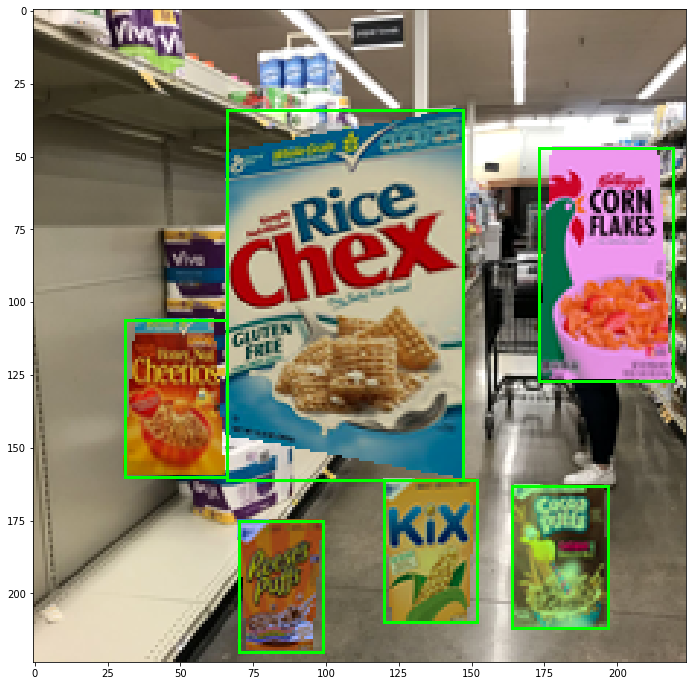

In [9]:
fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(np.array(bg_img));

for box in bboxes:
    rect = patches.Rectangle((box[0],box[1]), box[2], box[3], linewidth=3, edgecolor='lime',facecolor='none')
    ax.add_patch(rect);